In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

# from simulator import Simulation
from tqdm.auto import tqdm
import itertools
import matplotlib as mpl
from collections import OrderedDict

from voting_mechanism_design.agents.pairwise_badgeholder import PairwiseBadgeholder, PairwiseBadgeholderPopulation
from voting_mechanism_design.projects.project import Project, ProjectPopulation
from voting_mechanism_design.funds_distribution.pairwise_binary import PairwiseBinary
from voting_mechanism_design.sim import RoundSimulation

# OP simulator configuration
from voting_mechanism_design.legacy.op_simulator import Simulation as OPSimulation
from voting_mechanism_design.legacy.op_simulator import Round as OPRound
from voting_mechanism_design.legacy.op_simulator import Voter as OPVoter
from voting_mechanism_design.legacy.op_simulator import Project as OPProject

import itertools
import numpy as np
import choix
import math

import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

from tqdm.auto import tqdm
from joblib import Parallel, delayed

warnings.simplefilter(action='ignore', category=UserWarning)

In [3]:
def run_single_pairwise_simulation(
        n_badgeholders=50,
        badgeholder_expertise_vec=None,
        badgeholder_laziness_vec=None,
        n_projects=100,
        project_impact_vec=None,
        random_seed=1234
    ):
    # create badgeholders
    badgeholder_list = []
    for ii in range(n_badgeholders):
        badgeholder_id = ii
        expertise = badgeholder_expertise_vec[ii]
        laziness = badgeholder_laziness_vec[ii]
        
        coi_project_ids = []
        engaging_in_coi = False
        agent = PairwiseBadgeholder(
            badgeholder_id=badgeholder_id,
            voting_style='skewed_towards_impact',
            voting_style_kwargs={'use_impact_delta':False},
            expertise=expertise,
            laziness=laziness,
            coi_projects=coi_project_ids,
            engaging_in_coi=engaging_in_coi,
        )
        badgeholder_list.append(agent)
    badgeholders = PairwiseBadgeholderPopulation()
    badgeholders.add_badgeholders(badgeholder_list)

    # create projects
    projects = []
    for ii in range(n_projects):
        project_id = ii
        project_impact = project_impact_vec[ii]
        project = Project(
            project_id=project_id,
            true_impact=project_impact,  
            owner_id=None,  # used for COI modeling
        )
        projects.append(project)
    project_population = ProjectPopulation()
    project_population.add_projects(projects)

    # this is a no-op currently, but can change in the future
    fund_distribution_model = PairwiseBinary()

    # create and run a simulation
    simulation_obj = RoundSimulation(
        badgeholder_population=badgeholders,
        projects=project_population,
        funding_design=fund_distribution_model,
        random_seed=random_seed
    )

    # voters can vote on all projects, but an individual badgeholder can decide to ignore
    # some, based on the badgeholder configuration
    voting_view_ix = list(itertools.combinations(range(project_population.num_projects), 2))  # we need a list since we use this twice
    voting_view = []
    for ix1, ix2 in voting_view_ix:
        voting_view.append((project_population.get_project(ix1), project_population.get_project(ix2)))
    simulation_obj.run(cast_votes_kwargs={'view': voting_view})

    # store the project impact differences
    # this is only for diagnostics/post-hoc analysis
    impact_diff_vec = []
    for ix1, ix2 in voting_view_ix:
        p1 = project_population.get_project(ix1)
        p2 = project_population.get_project(ix2)
        impact_diff_vec.append(p1.true_impact - p2.true_impact)

    # make a matrix of all the pairwise voting possibilities
    all_votes = simulation_obj.badgeholder_population.get_all_votes()
    project_list = simulation_obj.projects.projects
    N = len(project_list)
    project_vote_matrix = np.zeros((N, N))
    project2ix = {p:ix for ix, p in enumerate(project_list)}
    vote_data_list = []

    # put the votes into the format needed by the choix package
    for v in all_votes:
        ix1 = project2ix[v.project1]
        ix2 = project2ix[v.project2]
        project_vote_matrix[ix1, ix2] += v.val1
        project_vote_matrix[ix2, ix1] += v.val2

        if v.val1 > v.val2:
            vote_data_list.append((ix1, ix2))
        elif v.val2 > v.val1:
            vote_data_list.append((ix2, ix1))
        else:
            # TODO: not sure if there is a tie, is that even possible??
            print('In Tie scenario!')
            pass

    # estimate parameters of bradley terry model - TODO: update to MCMC estimation
    try:
        params = choix.ilsr_pairwise(N, vote_data_list)  
    except Exception as e:
        print(f'Failed to estimate global rankings: {e}, adding some regularization!')
        params = choix.ilsr_pairwise(N, vote_data_list, alpha=0.01)
    # create rank order of project ids
    project_ix_worst_to_best_inferred = np.argsort(params)
    project_ix_best_to_worst_inferred = project_ix_worst_to_best_inferred[::-1]

    # # compare the inferred ranks to the actual ranks
    # actual_project_impacts = np.array([p.true_impact for p in project_list])
    # # rank them
    # project_ix_worst_to_best_actual = np.argsort(actual_project_impacts)
    # project_ix_best_to_worst_actual = project_ix_worst_to_best_actual[::-1]

    # return actual_project_impacts, project_ix_worst_to_best_inferred
    return params, project_ix_worst_to_best_inferred, impact_diff_vec

def run_single_simulation(
        n_badgeholders=50,
        badgeholder_expertise_vec=None,
        badgeholder_laziness_vec=None,
        n_projects=100,
        project_impact_vec=None,
        random_seed=1234
    ):
    # NOTE: this is a simple version which excludes
    # COI information.  We can build up the simulation to add this
    pairwise_project_scores, pairwise_project_ranks, impact_diff_vec = run_single_pairwise_simulation(
        n_badgeholders=n_badgeholders,
        badgeholder_expertise_vec=badgeholder_expertise_vec,
        badgeholder_laziness_vec=badgeholder_laziness_vec,
        n_projects=n_projects,
        project_impact_vec=project_impact_vec,
        random_seed=random_seed
    )

    # the results to return, but others may contain useful diagnostics as well!
    pairwise_inferred_rankings = pairwise_project_ranks
    true_project_rankings = np.argsort(project_impact_vec)
    
    # compute rank correlation as an initial measure of how aligned 
    tau_score = stats.kendalltau(project_impact_vec, pairwise_project_scores)
    tau_pairwise = stats.kendalltau(true_project_rankings, pairwise_inferred_rankings)

    return {
        'rankings': {
            'pairwise': pairwise_inferred_rankings,
            'true': true_project_rankings
        },
        'metrics': {
            # index-0 is the actual statistic, index-1 is a p-value or something
            'pairwise': tau_pairwise[0],
            'pairwise_score': tau_score[0],
        }
    }

def run_n_simulations(
        n_sims,
        n_badgeholders=50,
        badgeholder_expertise_vec=None,
        badgeholder_laziness_vec=None,
        n_projects=100,
        project_impact_vec=None,
        random_seed_start=1234,
        verbose=False,
    ):
    def run_simulation(ii):
        seed = random_seed_start + ii
        single_run_results = run_single_simulation(
            n_badgeholders=n_badgeholders,
            badgeholder_expertise_vec=badgeholder_expertise_vec,
            badgeholder_laziness_vec=badgeholder_laziness_vec,
            n_projects=n_projects,
            project_impact_vec=project_impact_vec,
            random_seed=seed
        )
        # return a dict so that we can create a dataframe of the results
        # for each configuration we test quickly
        return_dict = {
            'Pairwise': single_run_results['metrics']['pairwise'],
            'PS': single_run_results['metrics']['pairwise_score'],
            # 'Q+T': single_run_results['metrics']['qt'],
            # 'pw_rank': single_run_results['rankings']['pairwise'],
            # 'qt_rank': single_run_results['rankings']['qt'],
            'n_badgeholders': n_badgeholders,
            'avg_expertise': np.mean(badgeholder_expertise_vec),
            'avg_laziness': np.mean(badgeholder_laziness_vec),
            'n_projects': n_projects
        }
        return return_dict
    
    results = Parallel(n_jobs=-1)(delayed(run_simulation)(ii) for ii in tqdm(range(n_sims), disable=(not verbose)))
    # results = []
    # for ii in tqdm(range(n_sims), disable=(not verbose)):
    #     results.append(run_simulation(ii))

    return pd.DataFrame(results)


In [4]:
# setup simulation parameters
n_sims = 16

n_badgeholders_sweep = [25]
n_projects_sweep = [100]
badgeholder_expertise_sweep = [0.0, 0.25, 0.5, 0.75, 1.0]
badgeholder_laziness_sweep = [0.0, 0.25, 0.5, 0.75]
# TODO: make this w/ itertools ...
experiment_cfgs = []
for n_badgeholders in n_badgeholders_sweep:
    for n_projects in n_projects_sweep:
        for badgeholder_expertise in badgeholder_expertise_sweep:
            for badgeholder_laziness in badgeholder_laziness_sweep:
                experiment_cfgs.append((n_badgeholders, n_projects, badgeholder_expertise, badgeholder_laziness))
# parameters that we can explore
quorum=5
scoring_fn='mean'
min_vote_amt=1
max_vote_amt=16
max_funding=100

all_results = []
for experiment_cfg in tqdm(experiment_cfgs):
    n_badgeholders=experiment_cfg[0]
    n_projects=experiment_cfg[1]

    badgeholder_expertise_vec=np.ones(n_badgeholders) * experiment_cfg[2]
    badgeholder_laziness_vec=np.ones(n_badgeholders) * experiment_cfg[3]

    random_seed_start=123
    project_impact_vec=np.linspace(0, 1, n_projects)  # enforce a strict ranking that we can compare against

    results_df = run_n_simulations(
        n_sims,
        n_badgeholders=n_badgeholders,
        badgeholder_expertise_vec=badgeholder_expertise_vec,
        badgeholder_laziness_vec=badgeholder_laziness_vec,
        n_projects=n_projects,
        project_impact_vec=project_impact_vec,
        random_seed_start=random_seed_start,
        verbose=False
    )
    all_results.append(results_df)
all_results = pd.concat(all_results)

  0%|          | 0/20 [00:00<?, ?it/s]

/opt/anaconda3/envs/rpgf/lib/python3.11/site-packages/choix/utils.py:18: RuntimeWarning: divide by zero encountered in log
  params = np.log(weights)
/opt/anaconda3/envs/rpgf/lib/python3.11/site-packages/choix/utils.py:19: RuntimeWarning: invalid value encountered in subtract
  return params - params.mean()
/opt/anaconda3/envs/rpgf/lib/python3.11/site-packages/choix/utils.py:18: RuntimeWarning: divide by zero encountered in log
  params = np.log(weights)
/opt/anaconda3/envs/rpgf/lib/python3.11/site-packages/choix/utils.py:19: RuntimeWarning: invalid value encountered in subtract
  return params - params.mean()
/opt/anaconda3/envs/rpgf/lib/python3.11/site-packages/choix/utils.py:18: RuntimeWarning: divide by zero encountered in log
  params = np.log(weights)
/opt/anaconda3/envs/rpgf/lib/python3.11/site-packages/choix/utils.py:19: RuntimeWarning: invalid value encountered in subtract
  return params - params.mean()
/opt/anaconda3/envs/rpgf/lib/python3.11/site-packages/choix/utils.py:18: 

Failed to estimate global rankings: Did not converge after 100 iterations, adding some regularization!
Failed to estimate global rankings: Did not converge after 100 iterations, adding some regularization!
Failed to estimate global rankings: Did not converge after 100 iterations, adding some regularization!
Failed to estimate global rankings: Did not converge after 100 iterations, adding some regularization!
Failed to estimate global rankings: Did not converge after 100 iterations, adding some regularization!
Failed to estimate global rankings: Did not converge after 100 iterations, adding some regularization!
Failed to estimate global rankings: Did not converge after 100 iterations, adding some regularization!
Failed to estimate global rankings: Did not converge after 100 iterations, adding some regularization!


/opt/anaconda3/envs/rpgf/lib/python3.11/site-packages/choix/utils.py:18: RuntimeWarning: divide by zero encountered in log
  params = np.log(weights)
/opt/anaconda3/envs/rpgf/lib/python3.11/site-packages/choix/utils.py:19: RuntimeWarning: invalid value encountered in subtract
  return params - params.mean()
/opt/anaconda3/envs/rpgf/lib/python3.11/site-packages/choix/utils.py:18: RuntimeWarning: divide by zero encountered in log
  params = np.log(weights)
/opt/anaconda3/envs/rpgf/lib/python3.11/site-packages/choix/utils.py:19: RuntimeWarning: invalid value encountered in subtract
  return params - params.mean()
/opt/anaconda3/envs/rpgf/lib/python3.11/site-packages/choix/utils.py:18: RuntimeWarning: divide by zero encountered in log
  params = np.log(weights)
/opt/anaconda3/envs/rpgf/lib/python3.11/site-packages/choix/utils.py:19: RuntimeWarning: invalid value encountered in subtract
  return params - params.mean()
/opt/anaconda3/envs/rpgf/lib/python3.11/site-packages/choix/utils.py:18: 

Failed to estimate global rankings: Did not converge after 100 iterations, adding some regularization!
Failed to estimate global rankings: Did not converge after 100 iterations, adding some regularization!
Failed to estimate global rankings: Did not converge after 100 iterations, adding some regularization!
Failed to estimate global rankings: Did not converge after 100 iterations, adding some regularization!
Failed to estimate global rankings: Did not converge after 100 iterations, adding some regularization!
Failed to estimate global rankings: Did not converge after 100 iterations, adding some regularization!
Failed to estimate global rankings: Did not converge after 100 iterations, adding some regularization!
Failed to estimate global rankings: Did not converge after 100 iterations, adding some regularization!


/opt/anaconda3/envs/rpgf/lib/python3.11/site-packages/choix/utils.py:18: RuntimeWarning: divide by zero encountered in log
  params = np.log(weights)
/opt/anaconda3/envs/rpgf/lib/python3.11/site-packages/choix/utils.py:19: RuntimeWarning: invalid value encountered in subtract
  return params - params.mean()
/opt/anaconda3/envs/rpgf/lib/python3.11/site-packages/choix/utils.py:18: RuntimeWarning: divide by zero encountered in log
  params = np.log(weights)
/opt/anaconda3/envs/rpgf/lib/python3.11/site-packages/choix/utils.py:19: RuntimeWarning: invalid value encountered in subtract
  return params - params.mean()
/opt/anaconda3/envs/rpgf/lib/python3.11/site-packages/choix/utils.py:18: RuntimeWarning: divide by zero encountered in log
  params = np.log(weights)
/opt/anaconda3/envs/rpgf/lib/python3.11/site-packages/choix/utils.py:19: RuntimeWarning: invalid value encountered in subtract
  return params - params.mean()
/opt/anaconda3/envs/rpgf/lib/python3.11/site-packages/choix/utils.py:18: 

Failed to estimate global rankings: Did not converge after 100 iterations, adding some regularization!
Failed to estimate global rankings: Did not converge after 100 iterations, adding some regularization!
Failed to estimate global rankings: Did not converge after 100 iterations, adding some regularization!
Failed to estimate global rankings: Did not converge after 100 iterations, adding some regularization!
Failed to estimate global rankings: Did not converge after 100 iterations, adding some regularization!
Failed to estimate global rankings: Did not converge after 100 iterations, adding some regularization!
Failed to estimate global rankings: Did not converge after 100 iterations, adding some regularization!
Failed to estimate global rankings: Did not converge after 100 iterations, adding some regularization!


/opt/anaconda3/envs/rpgf/lib/python3.11/site-packages/choix/utils.py:18: RuntimeWarning: divide by zero encountered in log
  params = np.log(weights)
/opt/anaconda3/envs/rpgf/lib/python3.11/site-packages/choix/utils.py:19: RuntimeWarning: invalid value encountered in subtract
  return params - params.mean()
/opt/anaconda3/envs/rpgf/lib/python3.11/site-packages/choix/utils.py:18: RuntimeWarning: divide by zero encountered in log
  params = np.log(weights)
/opt/anaconda3/envs/rpgf/lib/python3.11/site-packages/choix/utils.py:19: RuntimeWarning: invalid value encountered in subtract
  return params - params.mean()
/opt/anaconda3/envs/rpgf/lib/python3.11/site-packages/choix/utils.py:18: RuntimeWarning: divide by zero encountered in log
  params = np.log(weights)
/opt/anaconda3/envs/rpgf/lib/python3.11/site-packages/choix/utils.py:19: RuntimeWarning: invalid value encountered in subtract
  return params - params.mean()
/opt/anaconda3/envs/rpgf/lib/python3.11/site-packages/choix/utils.py:18: 

Failed to estimate global rankings: Did not converge after 100 iterations, adding some regularization!
Failed to estimate global rankings: Did not converge after 100 iterations, adding some regularization!
Failed to estimate global rankings: Did not converge after 100 iterations, adding some regularization!
Failed to estimate global rankings: Did not converge after 100 iterations, adding some regularization!
Failed to estimate global rankings: Did not converge after 100 iterations, adding some regularization!
Failed to estimate global rankings: Did not converge after 100 iterations, adding some regularization!
Failed to estimate global rankings: Did not converge after 100 iterations, adding some regularization!
Failed to estimate global rankings: Did not converge after 100 iterations, adding some regularization!


/opt/anaconda3/envs/rpgf/lib/python3.11/site-packages/choix/utils.py:18: RuntimeWarning: divide by zero encountered in log
  params = np.log(weights)
/opt/anaconda3/envs/rpgf/lib/python3.11/site-packages/choix/utils.py:19: RuntimeWarning: invalid value encountered in subtract
  return params - params.mean()
/opt/anaconda3/envs/rpgf/lib/python3.11/site-packages/choix/utils.py:18: RuntimeWarning: divide by zero encountered in log
  params = np.log(weights)
/opt/anaconda3/envs/rpgf/lib/python3.11/site-packages/choix/utils.py:19: RuntimeWarning: invalid value encountered in subtract
  return params - params.mean()
/opt/anaconda3/envs/rpgf/lib/python3.11/site-packages/choix/utils.py:18: RuntimeWarning: divide by zero encountered in log
  params = np.log(weights)
/opt/anaconda3/envs/rpgf/lib/python3.11/site-packages/choix/utils.py:19: RuntimeWarning: invalid value encountered in subtract
  return params - params.mean()
/opt/anaconda3/envs/rpgf/lib/python3.11/site-packages/choix/utils.py:18: 

Failed to estimate global rankings: Did not converge after 100 iterations, adding some regularization!
Failed to estimate global rankings: Did not converge after 100 iterations, adding some regularization!
Failed to estimate global rankings: Did not converge after 100 iterations, adding some regularization!
Failed to estimate global rankings: Did not converge after 100 iterations, adding some regularization!
Failed to estimate global rankings: Did not converge after 100 iterations, adding some regularization!
Failed to estimate global rankings: Did not converge after 100 iterations, adding some regularization!
Failed to estimate global rankings: Did not converge after 100 iterations, adding some regularization!
Failed to estimate global rankings: Did not converge after 100 iterations, adding some regularization!


/opt/anaconda3/envs/rpgf/lib/python3.11/site-packages/choix/utils.py:18: RuntimeWarning: divide by zero encountered in log
  params = np.log(weights)
/opt/anaconda3/envs/rpgf/lib/python3.11/site-packages/choix/utils.py:19: RuntimeWarning: invalid value encountered in subtract
  return params - params.mean()
/opt/anaconda3/envs/rpgf/lib/python3.11/site-packages/choix/utils.py:18: RuntimeWarning: divide by zero encountered in log
  params = np.log(weights)
/opt/anaconda3/envs/rpgf/lib/python3.11/site-packages/choix/utils.py:19: RuntimeWarning: invalid value encountered in subtract
  return params - params.mean()
/opt/anaconda3/envs/rpgf/lib/python3.11/site-packages/choix/utils.py:18: RuntimeWarning: divide by zero encountered in log
  params = np.log(weights)
/opt/anaconda3/envs/rpgf/lib/python3.11/site-packages/choix/utils.py:19: RuntimeWarning: invalid value encountered in subtract
  return params - params.mean()
/opt/anaconda3/envs/rpgf/lib/python3.11/site-packages/choix/utils.py:18: 

Failed to estimate global rankings: Did not converge after 100 iterations, adding some regularization!
Failed to estimate global rankings: Did not converge after 100 iterations, adding some regularization!
Failed to estimate global rankings: Did not converge after 100 iterations, adding some regularization!
Failed to estimate global rankings: Did not converge after 100 iterations, adding some regularization!
Failed to estimate global rankings: Did not converge after 100 iterations, adding some regularization!
Failed to estimate global rankings: Did not converge after 100 iterations, adding some regularization!
Failed to estimate global rankings: Did not converge after 100 iterations, adding some regularization!
Failed to estimate global rankings: Did not converge after 100 iterations, adding some regularization!


/opt/anaconda3/envs/rpgf/lib/python3.11/site-packages/choix/utils.py:18: RuntimeWarning: divide by zero encountered in log
  params = np.log(weights)
/opt/anaconda3/envs/rpgf/lib/python3.11/site-packages/choix/utils.py:19: RuntimeWarning: invalid value encountered in subtract
  return params - params.mean()
/opt/anaconda3/envs/rpgf/lib/python3.11/site-packages/choix/utils.py:18: RuntimeWarning: divide by zero encountered in log
  params = np.log(weights)
/opt/anaconda3/envs/rpgf/lib/python3.11/site-packages/choix/utils.py:19: RuntimeWarning: invalid value encountered in subtract
  return params - params.mean()
/opt/anaconda3/envs/rpgf/lib/python3.11/site-packages/choix/utils.py:18: RuntimeWarning: divide by zero encountered in log
  params = np.log(weights)
/opt/anaconda3/envs/rpgf/lib/python3.11/site-packages/choix/utils.py:19: RuntimeWarning: invalid value encountered in subtract
  return params - params.mean()
/opt/anaconda3/envs/rpgf/lib/python3.11/site-packages/choix/utils.py:18: 

Failed to estimate global rankings: Did not converge after 100 iterations, adding some regularization!
Failed to estimate global rankings: Did not converge after 100 iterations, adding some regularization!
Failed to estimate global rankings: Did not converge after 100 iterations, adding some regularization!
Failed to estimate global rankings: Did not converge after 100 iterations, adding some regularization!
Failed to estimate global rankings: Did not converge after 100 iterations, adding some regularization!
Failed to estimate global rankings: Did not converge after 100 iterations, adding some regularization!
Failed to estimate global rankings: Did not converge after 100 iterations, adding some regularization!
Failed to estimate global rankings: Did not converge after 100 iterations, adding some regularization!


/opt/anaconda3/envs/rpgf/lib/python3.11/site-packages/choix/utils.py:18: RuntimeWarning: divide by zero encountered in log
  params = np.log(weights)
/opt/anaconda3/envs/rpgf/lib/python3.11/site-packages/choix/utils.py:19: RuntimeWarning: invalid value encountered in subtract
  return params - params.mean()
/opt/anaconda3/envs/rpgf/lib/python3.11/site-packages/choix/utils.py:18: RuntimeWarning: divide by zero encountered in log
  params = np.log(weights)
/opt/anaconda3/envs/rpgf/lib/python3.11/site-packages/choix/utils.py:19: RuntimeWarning: invalid value encountered in subtract
  return params - params.mean()
/opt/anaconda3/envs/rpgf/lib/python3.11/site-packages/choix/utils.py:18: RuntimeWarning: divide by zero encountered in log
  params = np.log(weights)
/opt/anaconda3/envs/rpgf/lib/python3.11/site-packages/choix/utils.py:19: RuntimeWarning: invalid value encountered in subtract
  return params - params.mean()
/opt/anaconda3/envs/rpgf/lib/python3.11/site-packages/choix/utils.py:18: 

Failed to estimate global rankings: Did not converge after 100 iterations, adding some regularization!
Failed to estimate global rankings: Did not converge after 100 iterations, adding some regularization!
Failed to estimate global rankings: Did not converge after 100 iterations, adding some regularization!
Failed to estimate global rankings: Did not converge after 100 iterations, adding some regularization!
Failed to estimate global rankings: Did not converge after 100 iterations, adding some regularization!
Failed to estimate global rankings: Did not converge after 100 iterations, adding some regularization!
Failed to estimate global rankings: Did not converge after 100 iterations, adding some regularization!
Failed to estimate global rankings: Did not converge after 100 iterations, adding some regularization!


In [7]:
dff = pd.melt(
    all_results, 
    value_vars=['PS'], value_name='Rank Corr', var_name='Mechanism',
    id_vars=['n_badgeholders', 'avg_expertise', 'avg_laziness', 'n_projects']
)

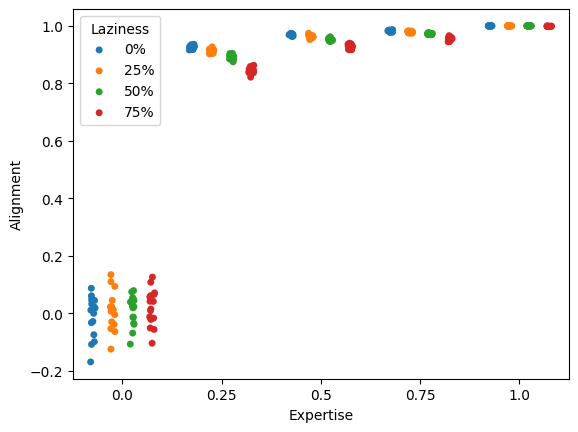

In [8]:
sns.stripplot(
    data=dff, x="avg_expertise", y="Rank Corr", hue="avg_laziness",
    dodge=True, zorder=1, legend=True, palette="tab10"
)
plt.xlabel('Expertise')
plt.ylabel('Alignment')
plt.legend(title="Laziness", labels=['0%', '25%', '50%', '75%'])